<a href="https://colab.research.google.com/github/GurjeetSinghSangra/MachineLearningAssignment/blob/main/emnist_DBN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##################################################
# Imports
##################################################

import numpy as np
import numpy.matlib
import math
import scipy.io
from sklearn import svm, datasets
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn #torch made by layers, in nn we have linear layer which implements standard forward fully connected layer
import torch.nn.functional as F 
import torchvision #used for data loading
import torch.optim as optim #optimizer for the gradient
from tqdm.notebook import tqdm
import time


# Setting the device
if torch.cuda.is_available(): 
    print('GPU enabled!')
    device = torch.device("cuda:0")
else:
    print('You are not using the GPU, activate it following:')
    

GPU enabled!


In [ ]:
def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image
    
images = np.apply_along_axis(rotate, 1, x_train)
plt.imshow(images[1,], cmap=plt.get_cmap('gray')) 

In [2]:
class DBN(nn.Module):

  def __init__(self, layers_nn, maxepochs=50, batchsize=125, epsilonw=0.1, \
                               sparsity=True, spars_factor=0.04, epsilonvb=0.1, epsilonhb=0.1, weightcost=0.0002, init_momentum=0.5, final_momentum=0.9):
    super(DBN, self).__init__()
    self.DN = {}
    self.DN['layersize'] = layers_nn
    self.DN['nlayers'] = len(layers_nn)
    self.DN['batchsize'] = batchsize
    self.DN['maxepochs'] = maxepochs
    self.epsilonw_GPU = epsilonw #learning rate DeltaW = epsilonw (pos_v * pos_h - neg_v * neg_h)
    self.epsilonvb=epsilonvb
    self.epsilonhb=epsilonhb
    self.weightcost = weightcost #constant weight decrease
    self.initialmomentum = init_momentum
    self.finalmomentum = final_momentum
    self.sparsity = sparsity
    self.spars_factor = spars_factor
    self.DN['errors'] = {}
  
  def train_dbn(self, batchdata, device):

    batchdata = batchdata.to(device)
    nlayers = self.DN['nlayers']
    for layer in range(0, nlayers):
        print ('Training layer ', layer+1, '...')
        if layer == 0:
            data_GPU = batchdata
        else:
            data_GPU = batchposhidprobs
        
        data_GPU.to(device)
        numhid = self.DN['layersize'][layer]
        numcases, numdims, numbatches = data_GPU.shape
        vishid_GPU       = 0.1 * torch.randn(numdims, numhid).to(device) #normal dist weights with standard deviation 0.01
        #print(vishid_GPU.shape)
        hidbiases_GPU    = torch.zeros(numhid).to(device)
        visbiases_GPU    = torch.zeros(numdims).to(device)
        vishidinc_GPU    = torch.zeros((numdims, numhid)).to(device)
        hidbiasinc_GPU   = torch.zeros(numhid).to(device)
        visbiasinc_GPU   = torch.zeros(numdims).to(device)
        batchposhidprobs = torch.zeros((numcases, numhid, numbatches)).to(device)
        self.DN['errors'][layer] = []


        sigmoid = nn.Sigmoid()
        for epoch in range(self.DN['maxepochs']):
            errsum = 0
            for mb in range(numbatches):
                data_mb = data_GPU[:, :, mb]
                #%%%%%%%% START POSITIVE PHASE %%%%%%%%%
                #1./(1 + exp(-poshidstates * vishid' - repmat(visbiases, numcases, 1))); 
                poshidprobs_GPU = sigmoid((torch.mm(data_mb, vishid_GPU) + hidbiases_GPU)).to(device)
                posprods_GPU    = torch.mm(data_mb.T, poshidprobs_GPU)
                poshidact_GPU   = poshidprobs_GPU.sum(0)
                #posvisact_GPU   = data_GPU[:, :, mb].sum(0)
                posvisact_GPU   = data_mb.sum(0)
                #%%%%%%%% END OF POSITIVE PHASE %%%%%%%%%
                poshidstates_GPU = poshidprobs_GPU > (torch.rand(numcases, numhid).to(device))
                poshidstates_GPU = torch.gt(poshidstates_GPU, 0).float()

                #%%%%%%%% START NEGATIVE PHASE  %%%%%%%%%
                negdata_GPU     = sigmoid((torch.mm(poshidstates_GPU, vishid_GPU.T) + visbiases_GPU))
                neghidprobs_GPU = sigmoid((torch.mm(negdata_GPU, vishid_GPU) + hidbiases_GPU))
                negprods_GPU    = torch.mm(negdata_GPU.T, neghidprobs_GPU)
                neghidact_GPU   = neghidprobs_GPU.sum(0)
                negvisact_GPU   = negdata_GPU.sum(0)
                #%%%%%%%% END OF NEGATIVE PHASE %%%%%%%%%
                
                err = torch.sqrt(torch.sum(torch.sum((data_mb - negdata_GPU)**2, dim=0)))
                if self.DN['maxepochs']  > 5:
                  self.momentum = self.finalmomentum
                else:
                  self.momentum = self.initialmomentum

                #%%%%%%%% UPDATE WEIGHTS AND BIASES %%%%%%%%%
                vishidinc_GPU  = vishidinc_GPU  * self.momentum + self.epsilonw_GPU * ((posprods_GPU - negprods_GPU) / numcases - self.weightcost * vishid_GPU)
                visbiasinc_GPU = visbiasinc_GPU * self.momentum + (posvisact_GPU - negvisact_GPU) * (self.epsilonvb / numcases)
                hidbiasinc_GPU = hidbiasinc_GPU * self.momentum + (poshidact_GPU - neghidact_GPU) * (self.epsilonhb / numcases)
                vishid_GPU     = vishid_GPU + vishidinc_GPU
                visbiases_GPU  = visbiases_GPU + visbiasinc_GPU
                hidbiases_GPU  = hidbiases_GPU + hidbiasinc_GPU
                #%%%%%%%% END OF UPDATES %%%%%%%%%
                # END RBM
                
                errsum = err + errsum

                if epoch == self.DN['maxepochs']-1:
                    batchposhidprobs[:, :, mb] = poshidprobs_GPU

                #TODO: Sparsity
                if self.sparsity and (layer == nlayers-1):
                  #poshidact_GPU = poshidprobs_GPU.sum(0)
                  Q = poshidact_GPU / self.DN['batchsize']
                  if (torch.mean(Q) > self.spars_factor):
                    hidbiases_GPU = hidbiases_GPU - self.epsilonhb * (Q - self.spars_factor)
              
            #END Batches
            self.DN['errors'][layer].append((epoch, errsum.cpu().clone().numpy()))
          #END Epoches

        # save learned weights
        self.DN['vis_bias' + str(layer)] = visbiases_GPU.cpu().clone().numpy()
        self.DN['hid_bias' + str(layer)] = hidbiases_GPU.cpu().clone().numpy()
        self.DN['vishid'   + str(layer)] = vishid_GPU.cpu().clone().numpy()
        #print(self.DN['vishid'   + str(layer)].shape)

  def load_data(fname, NUMB_CLASSES, batchsize):
    dataset = scipy.io.loadmat(fname)
    data_train = dataset['dataset']['train']
    data_test = dataset['dataset']['test']
    x_train = data_train[0,0]['images'][0,0]
    x_train = x_train.astype('float32') / 255
    y_train = data_train[0,0]['labels'][0,0]
    y_train = y_train.astype(int)
    x_test = data_test[0,0]['images'][0,0]
    x_test = x_test.astype('float32')  / 255
    y_test = data_test[0,0]['labels'][0,0]
    y_test = y_test.astype(int)

    iterations = int(len(x_train)/batchsize)
    batchdata = np.zeros(shape=(batchsize,784,iterations), dtype='float32')
    for i in range(iterations) :
        for j in range(batchsize):
            batchdata[j, :,i] = x_train[i+j, :]

    length_train = int(len(x_train))
    tr_labels = np.zeros(shape=(length_train, NUMB_CLASSES))
    for i in range(length_train):
        tr_labels[i, y_train[i]] = 1

    length_test = int(len(y_test))
    te_labels = np.zeros(shape=(length_test, NUMB_CLASSES))
    for i in range(length_test):
        te_labels[i, y_test[i]] = 1

    x_trainGPU = torch.from_numpy(batchdata)
    return (x_train, tr_labels, x_test, te_labels, x_trainGPU)

  

In [ ]:
class LinearSVM(nn.Module):
    """Support Vector Machine"""

    def __init__(self):
        super(LinearSVM, self).__init__()
        self.w = nn.Parameter(torch.randn(1, 2), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)

    def forward(self, x):
        h = x.matmul(self.w.t()) + self.b
        return h

    def hinge_loss(y_pred, y_true):
      return torch.mean(torch.clamp(1 - y_pred.t() * y_true, min=0))

svm = LinearSVM()
model = Trial(svm, optim.SGD(svm.parameters(), 0.1), hinge_loss, ['loss'],
              callbacks=[scatter, draw_margin, ExponentialLR(0.999, step_on_batch=True), L2WeightDecay(0.01, params=[svm.w])]).to('cuda')
model.with_train_data(X, Y, batch_size=32)
model.run(epochs=50, verbose=1)

plt.ioff()
plt.show()

In [3]:
from scipy.linalg import lstsq
def perceptron_CPU(tr_patterns, tr_labels, te_patterns, te_labels):

  te_accuracy = 0;
  tr_accuracy = 0;

  # add biases
  tr_patterns_CPU = np.hstack((tr_patterns, np.ones((len(tr_patterns), 1))))

  print(tr_patterns_CPU.shape)
  print(tr_labels.shape)
  # train with pseudo-inverse
  weights, res, rnk, s= lstsq(tr_patterns_CPU, tr_labels)
  #weights = (tr_labels'*pinv(tr_patterns'))';

  # training accuracy
  print(weights.shape)
  pred = np.dot(tr_patterns_CPU, weights)
  print(pred.shape)
  max_act_idx = np.argmax(pred, axis=1)
  r = np.nonzero(tr_labels)[1]
  acc = max_act_idx == r

  tr_accuracy = np.mean(acc)

  # test accuracy
  te_patterns_CPU = np.hstack((te_patterns, np.ones((len(te_patterns), 1))))
  pred = np.dot(te_patterns_CPU, weights)
  max_act_idx = np.argmax(pred, axis=1)
  r = np.nonzero(te_labels)[1]
  acc = (max_act_idx == r)
  te_accuracy = np.mean(acc)

  return (weights, tr_accuracy, te_accuracy)

In [14]:
x1 = time.strftime('%s')
namedataset = 'balanced'
fname = ('/home/emnist-' + namedataset + '.mat')
#MNIST Train 60000 ---> 125 --> 480
#Letters Train 124800 ---> 260 or 240
#Digits Train 240000 --->
#Balanced Train 112800 --> 
batch_dict = {"mnist" : 125,
              "letters" : [260],
              "digits" : [400],
              "balanced" :  [200]}

layers_nn = np.array([784, 500, 500, 2000]) # 1400
dbn_models = []

x2 = time.strftime('%s')
timediff = int(x2) - int(x1)

i = 1
#make dbn models
for batch_size in  batch_dict[namedataset] :
  dbn_model = DBN(layers_nn = layers_nn, epsilonw=0.03, batchsize=batch_size, maxepochs=200, sparsity=False)
  dbn_models.append(dbn_model)
  i = i + 1

#print '\nElapsed time: ', timediff, ' seconds.'
# save final network and parameters
#scipy.io.savemat('DN.mat', {'DN': DN})

In [15]:
i=1
for dbn_model in dbn_models:
  print("DBN model {0} training".format(i))
  dbn_model = dbn_model.to(device)
  _, _, _, _, x_trainGPU = DBN.load_data(fname, int(47), dbn_model.DN['batchsize'])
  dbn_model.train_dbn(x_trainGPU, device=device)
  i = i + 1

DBN model 1 training
Training layer  1 ...
Training layer  2 ...
Training layer  3 ...
Training layer  4 ...


In [18]:
del x_trainGPU
i = 1
for dbn_model in dbn_models:
  x_train, y_train, x_test, y_test, x_trainGPU = DBN.load_data(fname, int(47), dbn_model.DN['batchsize'])
  del x_trainGPU
  (weights, tr_accuracy, te_accuracy) = perceptron_CPU(x_train, y_train, x_test, y_test)
  print('Raw Data perceptron Accuracy: {0:.2f}, test accuracy: {1:.2f}'.format(tr_accuracy * 100, te_accuracy * 100))

  print("DBN model {0} batch_size {1}".format(i, dbn_model.DN['batchsize']))
  vishid0 = dbn_model.DN['vishid0']
  hid_bias0 = dbn_model.DN['hid_bias0']
  H0_tr = 1 /(1 + np.exp(-np.dot(x_train, vishid0) - np.matlib.repmat(hid_bias0, len(x_train), 1)));
  H0_te = 1 /(1 + np.exp(-np.dot(x_test, vishid0) - np.matlib.repmat(hid_bias0, len(x_test), 1)));
  (weights, tr_accuracy, te_accuracy) = perceptron_CPU(H0_tr, y_train, H0_te, y_test)
  print('Read out Level 1 DBN layer accuracy: {0:.2f}, test accuracy: {1:.2f}'.format(tr_accuracy * 100, te_accuracy * 100))

  vishid1= dbn_model.DN['vishid1']
  hid_bias1 = dbn_model.DN['hid_bias1']
  H1_tr = 1 /(1 + np.exp(-np.dot(H0_tr, vishid1) - np.matlib.repmat(hid_bias1, len(H0_tr), 1)));
  H1_te = 1 /(1 + np.exp(-np.dot(H0_te, vishid1) - np.matlib.repmat(hid_bias1, len(H0_te), 1)));
  (weights, tr_accuracy, te_accuracy) = perceptron_CPU(H1_tr, y_train, H1_te, y_test);
  print('Read out Level 2 DBN layer accuracy: {0:.2f}, test accuracy: {1:.2f}'.format(tr_accuracy * 100, te_accuracy * 100))

  vishid2= dbn_model.DN['vishid2']
  hid_bias2 = dbn_model.DN['hid_bias2']
  H2_tr = 1 /(1 + np.exp(-np.dot(H1_tr, vishid2) - np.matlib.repmat(hid_bias2, len(H1_tr), 1)));
  H2_te = 1 /(1 + np.exp(-np.dot(H1_te, vishid2) - np.matlib.repmat(hid_bias2, len(H1_te), 1)));
  (weights, tr_accuracy, te_accuracy) = perceptron_CPU(H2_tr, y_train, H2_te, y_test);
  print('Read out Level 3 DBN layer accuracy: {0:.2f}, test accuracy: {1:.2f}'.format(tr_accuracy * 100, te_accuracy * 100))

  i = i +1

(112800, 785)
(112800, 47)
(785, 47)
(112800, 47)
Raw Data perceptron Accuracy: 55.30, test accuracy: 52.55
DBN model 1 batch_size 200
(112800, 785)
(112800, 47)
(785, 47)
(112800, 47)
Read out Level 1 DBN layer accuracy: 70.88, test accuracy: 69.05
(112800, 501)
(112800, 47)
(501, 47)
(112800, 47)
Read out Level 2 DBN layer accuracy: 70.09, test accuracy: 69.29
(112800, 501)
(112800, 47)
(501, 47)
(112800, 47)
Read out Level 3 DBN layer accuracy: 68.73, test accuracy: 67.59


In [19]:
vishid3= dbn_model.DN['vishid3']
hid_bias3 = dbn_model.DN['hid_bias3']
H3_tr = 1 /(1 + np.exp(-np.dot(H2_tr, vishid3) - np.matlib.repmat(hid_bias3, len(H2_tr), 1)));
H3_te = 1 /(1 + np.exp(-np.dot(H2_te, vishid3) - np.matlib.repmat(hid_bias3, len(H2_te), 1)));
(weights, tr_accuracy, te_accuracy) = perceptron_CPU(H3_tr, y_train, H3_te, y_test);
print('Raw data perceptron training accuracy: {0:.2f}, test accuracy: {1:.2f}'.format(tr_accuracy * 100, te_accuracy * 100))

(112800, 2001)
(112800, 47)
(2001, 47)
(112800, 47)
Raw data perceptron training accuracy: 77.05, test accuracy: 75.13


In [20]:
for dbn_model in dbn_models:
  batchsize = dbn_model.DN['batchsize']
  savematname = 'DN_COLAB_{0}_{1}.mat'.format(batchsize, namedataset)
  scipy.io.savemat(savematname, {'DN': dbn_model.DN})
  print(savematname)

DN_COLAB_200_balanced.mat


In [21]:
dbn_model = dbn_models[0]
x_train, y_train, x_test, y_test, x_trainGPU = DBN.load_data(fname, int(47), dbn_model.DN['batchsize'])

In [27]:
linear_model = nn.Linear(x_train.shape[1], y_train.shape[1])
x_train_GPU = torch.tensor(x_train).to(device)
weights = linear_model(x_train)
print(weights.shape)

AttributeError: ignored

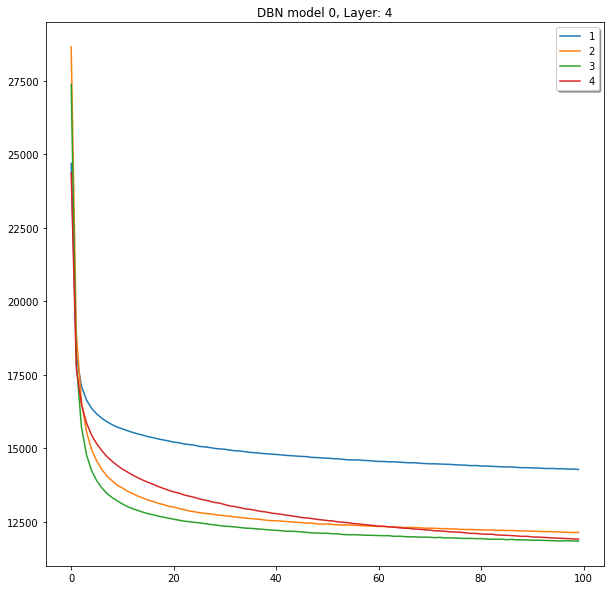

In [ ]:
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

i=0
n_models = len(dbn_models)
fig, axes = plt.subplots(n_models, figsize=(10,10))

for dbn_model in dbn_models:
  nlayers = dbn_model.DN['nlayers']
  legends = []
  legend_name = []
  if n_models > 1:
      axis = axes[i]
  else:
      axis = axes
  for layer in range(nlayers):
    values = dbn_model.DN['errors'][layer]
    x, y = zip(*values)
    title = 'DBN model {0}, Layer: {1}'.format(i, layer+1)
    
    leg,  = axis.plot(x, y)
    legends.append(leg)
    legend_name.append(str(layer+1))

  axis.legend(legends, legend_name, loc='upper right', shadow=True)
  axis.set_title(title)
  i+=1

plt.show()


In [ ]:
values = dbn_models[0].DN['errors']
values = []
values.append()

{0: (99, array(14309.258, dtype=float32)),
 1: (99, array(12149.0205, dtype=float32)),
 2: (99, array(11768.902, dtype=float32)),
 3: (99, array(11887.091, dtype=float32))}

(784, 784)


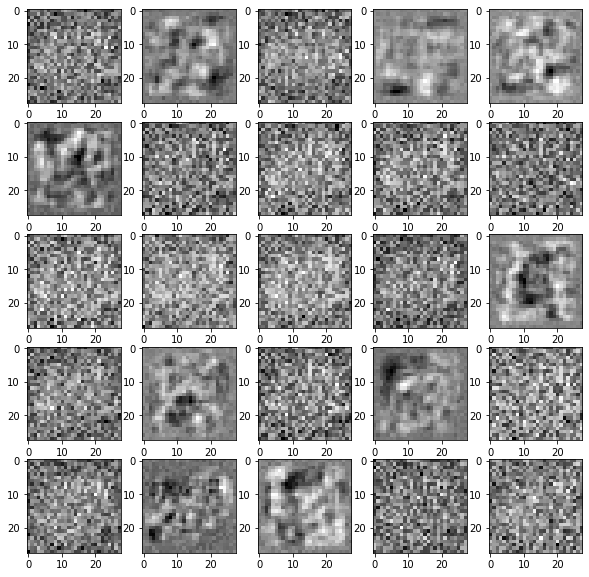

In [ ]:
learned_weights = dbn_model.DN['vishid0'].transpose(1, 0)
print(learned_weights.shape)
plt.show()
fig = plt.figure(3, figsize=(10,10))
for i in range(25): 
    sub = fig.add_subplot(5, 5, i+1)
    sub.imshow(learned_weights[i,:].reshape((28,28)), cmap=plt.cm.gray)
plt.show()

In [ ]:
import cv2 as cv
def plot_layer(DN, n_hidden):
  #self.DN['vis_bias' layer]
  #self.DN['hid_bias' layer]
  v, h = DN['vishid1'].shape # number of visible and hidden units
  imgsize = math.sqrt(v);
  if n_hidden > h:
      n_hidden = h;

  n_x = math.floor(math.sqrt(n_hidden))
  n_y = n_x
  n_hidden = n_x * n_y;

  plt.show()
  fig = plt.figure(3, figsize=(10,10)) 
  for i_n in range(n_hidden):
    # Select (strong) inputs to L3(i_n)
    W3 = DN['vishid2'][:, i_n]
    #W3 = W3.detach().cpu().clone().numpy()
    W3 = np.multiply(W3, (np.abs(W3) > 0.0))
    # Select (strong) inputs to L2
    W2 = DN['vishid1']
    #W2 = W2.detach().cpu().clone().numpy()
    W2 = np.multiply(W2, (np.abs(W2) > 0.0))
    # Select (strong) inputs to L1
    W1 = DN['vishid0']
    #W1 = W1.detach().cpu().clone().numpy()
    W1 = np.multiply(W1, (np.abs(W1) > 0.0))
    
    # Weight filters with a linear combination
    ww = np.dot(W1, W2)
    ww = np.dot(ww, W3)
    ww = np.multiply(ww, np.abs(ww) > 0.0) # threshold
    print(max(abs(ww)))
    ww=ww/max(abs(ww))

    print(ww.shape)
    #print(ww)
    sub = fig.add_subplot(n_y, n_x, i+1)
    sub.imshow(ww.reshape((imgsize, imgsize)), cmap=plt.cm.gray)
    plt.show()
    #pl = subplot(n_y, n_x, i_n)
    #imagesc(reshape(ww,imgsize,imgsize)); %(1:end-2)
    #colormap('gray'); axis square; axis off


In [ ]:
plot_layer(dbn_model.DN, 100)